## GAP-TV for Video Compressive Sensing
### GAP-TV
> X. Yuan, "Generalized alternating projection based total variation minimization for compressive sensing," in *IEEE International Conference on Image Processing (ICIP)*, 2016, pp. 2539-2543.
### Code credit
[Xin Yuan](https://www.bell-labs.com/usr/x.yuan "Dr. Xin Yuan, Bell Labs"), [Bell Labs](https://www.bell-labs.com/), xyuan@bell-labs.com, created Aug 7, 2018.  
[Yang Liu](https://liuyang12.github.io "Yang Liu, Tsinghua University"), [Tsinghua University](http://www.tsinghua.edu.cn/publish/thu2018en/index.html), y-liu16@mails.tsinghua.edu.cn, updated Jan 20, 2019.

First we install conda :

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

We create the environment :

In [ ]:
!conda create --name pnpnsci python=3.11

We install the required packages :

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
  Using cached https://download.pytorch.org/whl/numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
  Usin

In [3]:
!pip install torch torchvision torchaudio matplotlib jupyterlab h5py tifffile tensorboardX scikit-image scipy opencv-python colour-science colour_demosaicing

  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached jupyterlab-4.3.5-py3-none-any.whl.metadata (16 kB)
  Using cached h5py-3.13.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached tifffile-2025.2.18-py3-none-any.whl.metadata (31 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached scikit_image-0.25.2-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.15.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached colour_science-0.4.6-py3-none-any.whl.metadata (54 kB)
  Using cached colour_demosaicing-0.2.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.w

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())  # Should return True if CUDA is available
print("CUDA version:", torch.version.cuda)  # Should return the installed CUDA version (e.g., 11.8)
print("Device count:", torch.cuda.device_count())  # Number of GPUs detected
print("Current device:", torch.cuda.current_device())  # Index of current device
print("Device name:", torch.cuda.get_device_name(0))  # Name of the detected GPU (e.g., NVIDIA RTX 3060)


CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


We clone the repository :

In [ ]:
!git clone https://github.com/MohamedAkkAdir/PnPGAP_SCI.git

Change the directory :

In [ ]:
%cd PnPGAP_SCI/python

In [12]:
import os
import time
import math
import h5py
import skimage
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from statistics import mean


from pnp_sci_algo import admmdenoise_cacti

from utils import (A_, At_)

In [13]:
import scipy.io as sio
import h5py
import numpy as np

def load_mat_data(matfile):
    try:
        # Try loading the file as a v7.2 (or earlier) MAT-file
        file = sio.loadmat(matfile)
        meas = np.float32(file['meas'])
        mask = np.float32(file['mask'])
        orig = np.float32(file['orig'])
    except NotImplementedError:
        # If the file is v7.3, load it using h5py
        file = h5py.File(matfile, 'r')  # Open the file in read-only mode
        # Switch to MATLAB array order by transposing
        meas = np.float32(file['meas'][:]).transpose()  # Read the dataset and transpose
        mask = np.float32(file['mask'][:]).transpose()
        orig = np.float32(file['orig'][:]).transpose()

    return meas, mask, orig

matfile = "dataset/simdata/runner.mat"
meas, mask, orig = load_mat_data(matfile)


In [ ]:
iframe = 0
nframe = 1
# nframe = meas.shape[2]
MAXB = 255.

# common parameters and pre-calculation for PnP
# define forward model and its transpose
A  = lambda x :  A_(x, mask) # forward model function handle
At = lambda y : At_(y, mask) # transpose of forward model

mask_sum = np.sum(mask, axis=2)
mask_sum[mask_sum==0] = 1

In [15]:
## [2.3] GAP/ADMM-TV
### [2.3.1] GAP-TV
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'tv' # total variation (TV)
iter_max = 40 # maximum number of iterations
tv_weight = 0.3 # TV denoising weight (larger for smoother but slower)
tv_iter_max = 5 # TV denoising maximum number of iterations each

vgaptv,tgaptv,psnr_gaptv,ssim_gaptv,psnrall_gaptv = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate,
                                          denoiser=denoiser, iter_max=iter_max, 
                                          tv_weight=tv_weight, 
                                          tv_iter_max=tv_iter_max)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gaptv), mean(ssim_gaptv), tgaptv))

GAP-TV Reconstruction coded frame block  1 of  1 ...
  GAP-TV iteration   5, PSNR 18.81 dB.
  GAP-TV iteration  10, PSNR 27.91 dB.
  GAP-TV iteration  15, PSNR 29.32 dB.
  GAP-TV iteration  20, PSNR 29.63 dB.
  GAP-TV iteration  25, PSNR 29.70 dB.
  GAP-TV iteration  30, PSNR 29.71 dB.
  GAP-TV iteration  35, PSNR 29.72 dB.
  GAP-TV iteration  40, PSNR 29.73 dB.
GAP-TV PSNR 29.76 dB, SSIM 0.9140, running time 3.3 seconds.


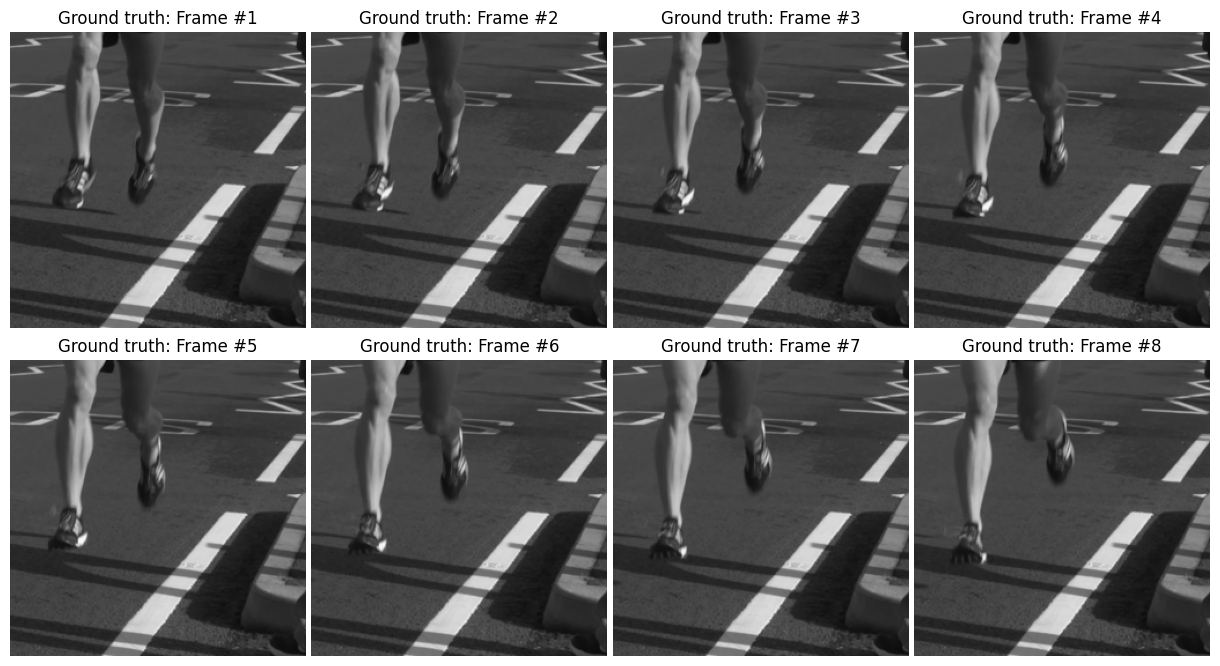

Mean PSNR 29.76 dB.


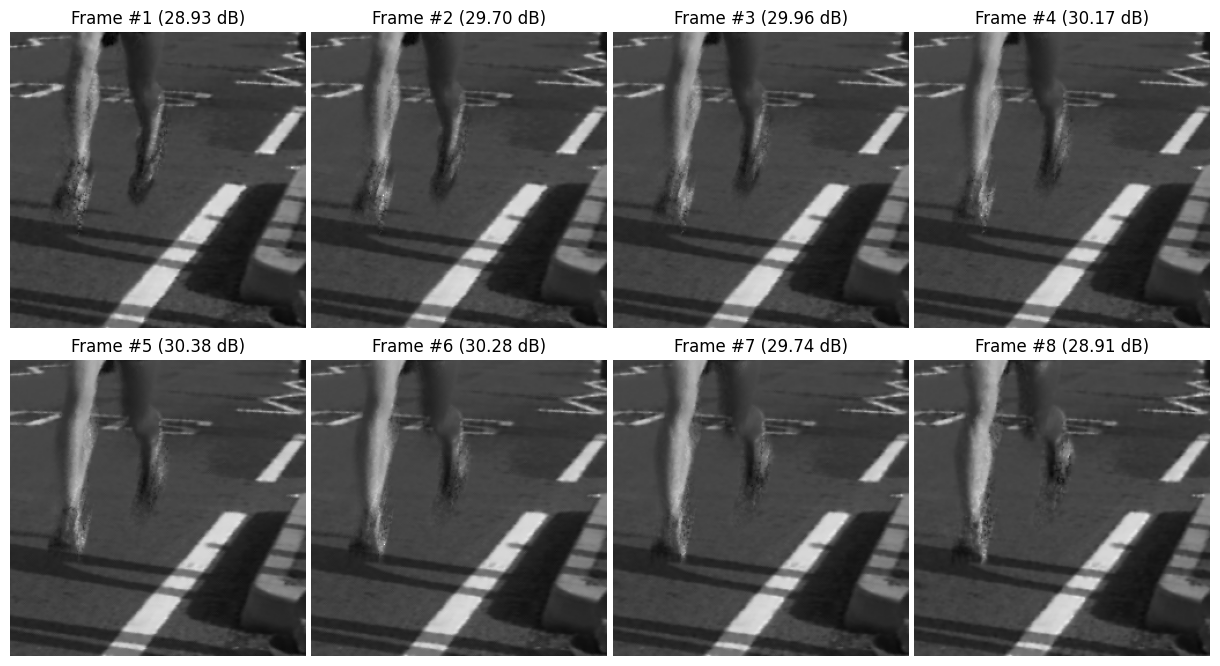

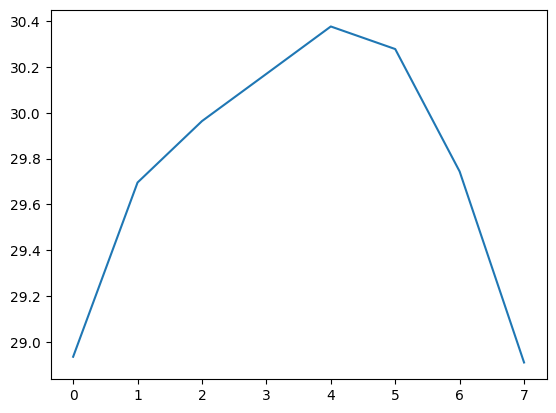

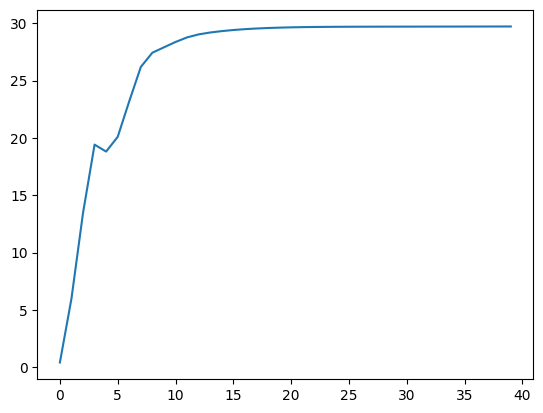

In [58]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgaptv
psnr_gapdenoise = psnr_gaptv
psnrall_gapdenoise = psnrall_gaptv[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()




In [59]:
### [2.3.2] ADMM-TV
projmeth = 'admm' # projection method
_lambda = 1 # regularization factor
gamma = 0.01 # parameter in ADMM projection (greater for more noisy data)
denoiser = 'tv' # total variation (TV)
iter_max = 40 # maximum number of iterations
tv_weight = 0.3 # TV denoising weight (larger for smoother but slower)
tv_iter_max = 5 # TV denoising maximum number of iterations each

vadmmtv,tadmmtv,psnr_admmtv,ssim_admmtv,psnrall_admmtv = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, gamma=gamma,
                                          denoiser=denoiser, iter_max=iter_max, 
                                          tv_weight=tv_weight, 
                                          tv_iter_max=tv_iter_max)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_admmtv), mean(ssim_admmtv), tadmmtv))

ADMM-TV Reconstruction coded frame block  1 of  1 ...
  ADMM-TV iteration   5, PSNR  24.00 dB.
  ADMM-TV iteration  10, PSNR  29.10 dB.
  ADMM-TV iteration  15, PSNR  29.59 dB.
  ADMM-TV iteration  20, PSNR  29.69 dB.
  ADMM-TV iteration  25, PSNR  29.70 dB.
  ADMM-TV iteration  30, PSNR  29.70 dB.
  ADMM-TV iteration  35, PSNR  29.70 dB.
  ADMM-TV iteration  40, PSNR  29.71 dB.
ADMM-TV PSNR 29.74 dB, SSIM 0.9143, running time 3.1 seconds.


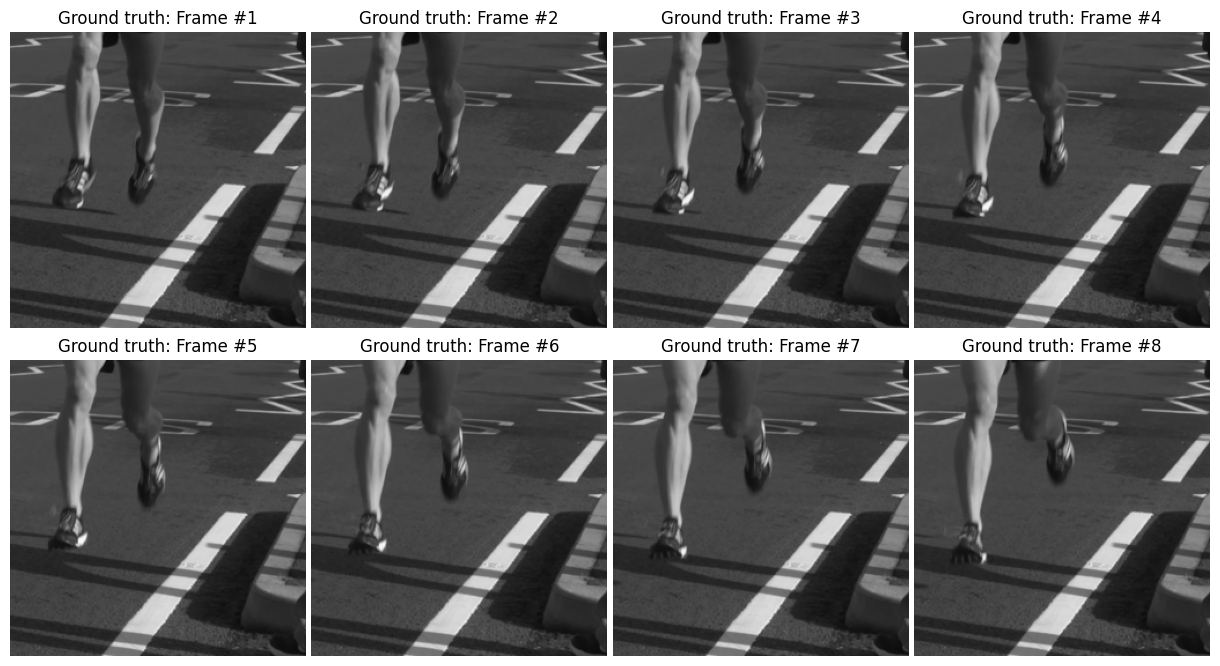

Mean PSNR 29.74 dB.


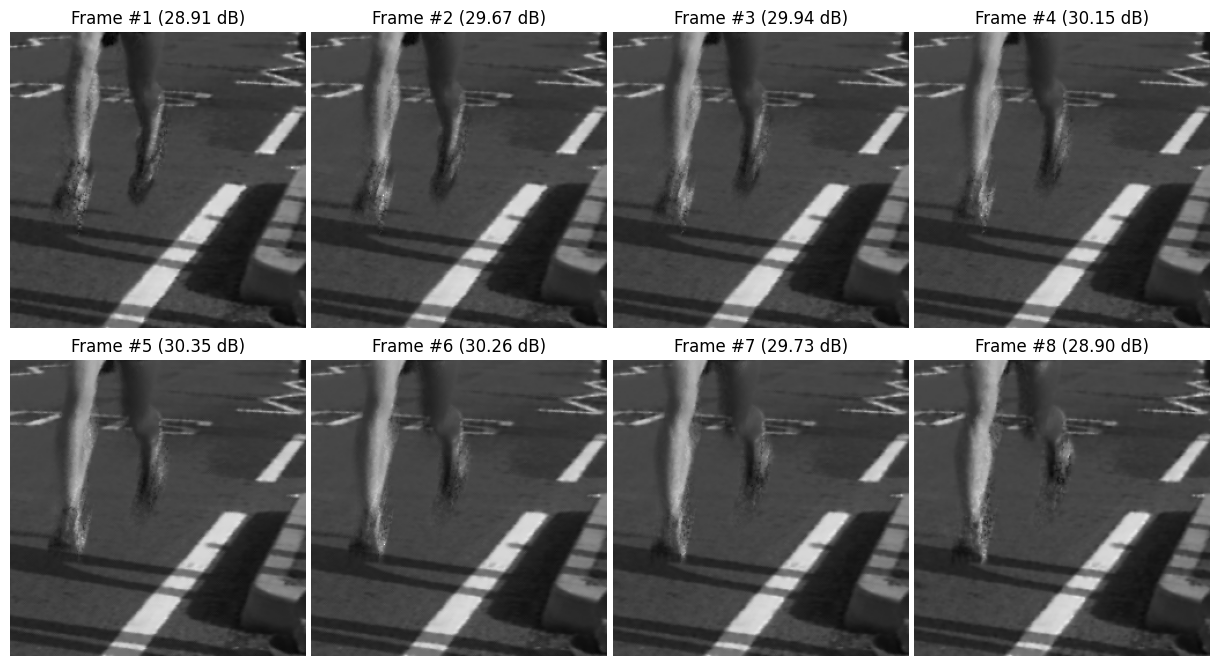

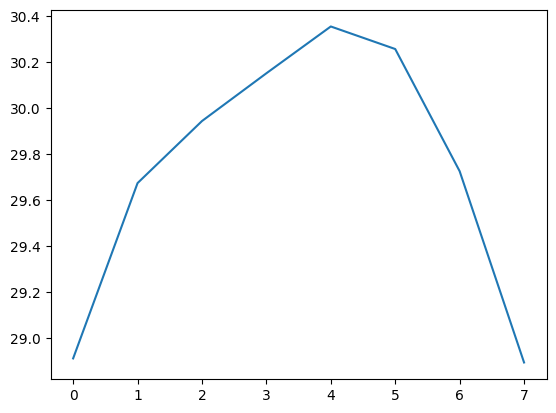

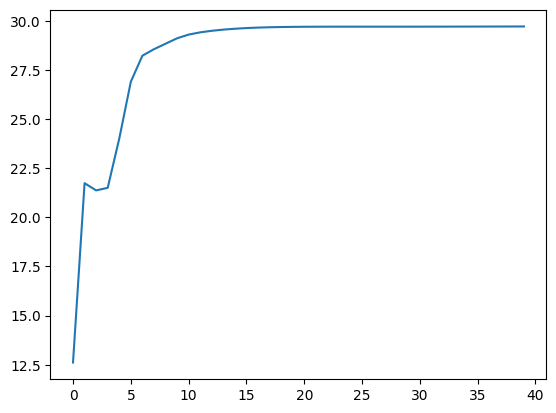

In [60]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vadmmtv
psnr_gapdenoise = psnr_admmtv
psnrall_gapdenoise = psnrall_admmtv[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()




In [16]:
import torch
from packages.ffdnet.models import FFDNet
from packages.ffdnet.utils import remove_dataparallel_wrapper

## [2.5] GAP/ADMM-FFDNet
### [2.5.1] GAP-FFDNet (FFDNet-based frame-wise video denoising)
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAPs
denoiser = 'ffdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
sigma    = [50/255, 25/255, 12/255, 6/255] # pre-set noise standard deviation
iter_max = [10, 10, 10, 10] # maximum number of iterations
# sigma    = [12/255, 6/255] # pre-set noise standard deviation
# iter_max = [10,10] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for FFDNet image denoising
in_ch = 1
model_fn = 'packages/ffdnet/models/net_gray.pth'
# Absolute path to model file
# model_fn = os.path.join(os.path.abspath(os.path.dirname(__file__)), model_fn)

# Create model
net = FFDNet(num_input_channels=in_ch)
# Load saved weights
if useGPU:
    state_dict = torch.load(model_fn, weights_only=False)
    device_ids = [0]
    model = torch.nn.DataParallel(net, device_ids=device_ids).cuda()
else:
    state_dict =  torch.load(model_fn, weights_only=False)
    # CPU mode: remove the DataParallel wrapper
    state_dict = remove_dataparallel_wrapper(state_dict)
    model = net
model.load_state_dict(state_dict)
model.eval() # evaluation mode

vgapffdnet,tgapffdnet,psnr_gapffdnet,ssim_gapffdnet,psnrall_gapffdnet = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate,
                                          denoiser=denoiser, model=model, 
                                          iter_max=iter_max, sigma=sigma)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gapffdnet), mean(ssim_gapffdnet), tgapffdnet))

GAP-FFDNET Reconstruction coded frame block  1 of  1 ...
  GAP-FFDNET iteration   5, sigma  50/255, PSNR 20.62 dB.
  GAP-FFDNET iteration  10, sigma  50/255, PSNR 27.99 dB.
  GAP-FFDNET iteration  15, sigma  25/255, PSNR 30.20 dB.
  GAP-FFDNET iteration  20, sigma  25/255, PSNR 30.86 dB.
  GAP-FFDNET iteration  25, sigma  12/255, PSNR 31.96 dB.
  GAP-FFDNET iteration  30, sigma  12/255, PSNR 32.22 dB.
  GAP-FFDNET iteration  35, sigma   6/255, PSNR 32.45 dB.
  GAP-FFDNET iteration  40, sigma   6/255, PSNR 32.44 dB.
GAP-FFDNET PSNR 32.44 dB, SSIM 0.9312, running time 2.5 seconds.


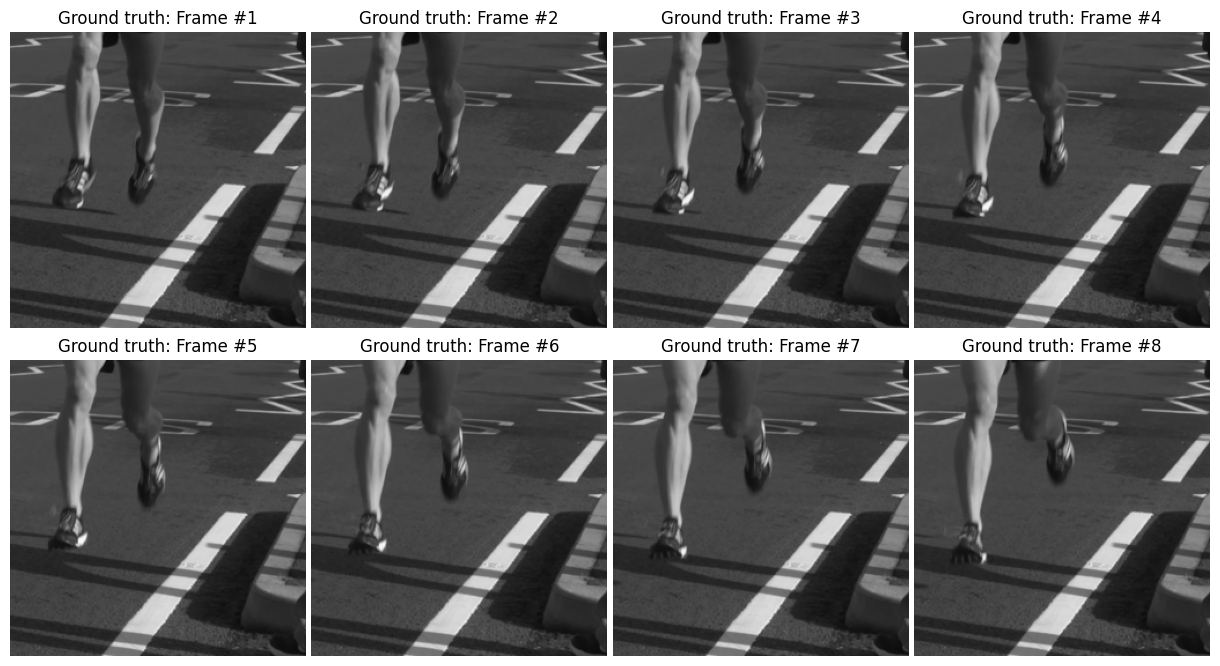

Mean PSNR 32.44 dB.


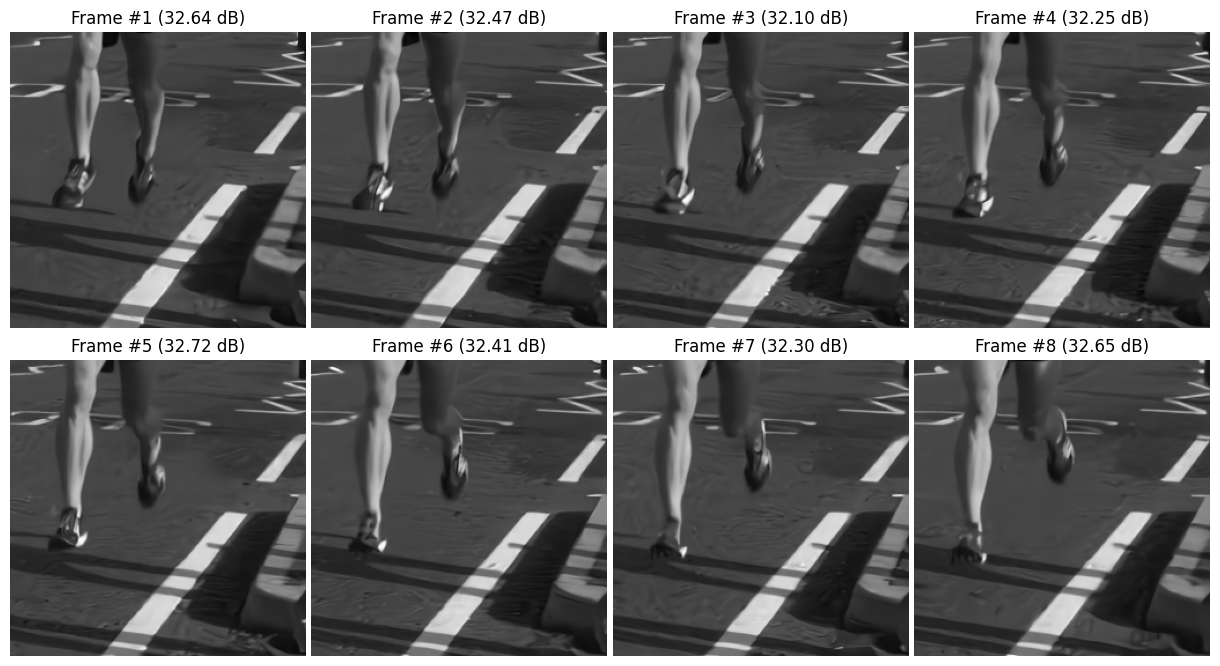

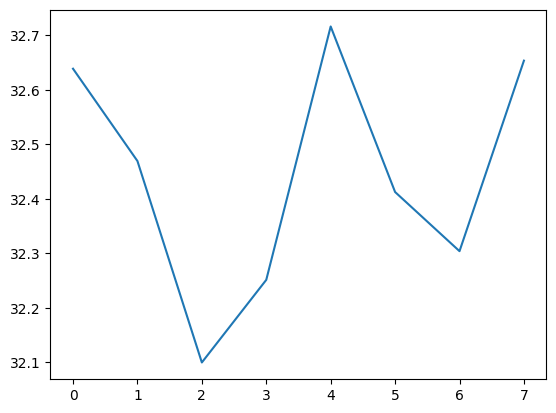

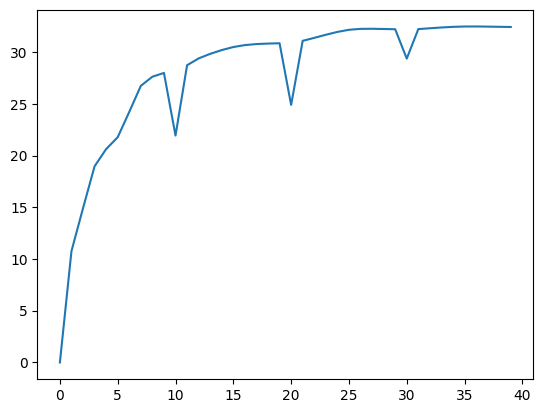

In [62]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgapffdnet
psnr_gapdenoise = psnr_gapffdnet
psnrall_gapdenoise = psnrall_gapffdnet[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()




In [63]:
import torch
from packages.fastdvdnet.models import FastDVDnet

## [2.2] GAP-FastDVDnet
projmeth = 'gap' # projection method
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'fastdvdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
sigma    = [100/255, 50/255, 25/255, 12/255] # pre-set noise standard deviation
iter_max = [20, 20, 20, 20] # maximum number of iterations
# sigma    = [12/255] # pre-set noise standard deviation
# iter_max = [20] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for fastdvdnet image denoising
NUM_IN_FR_EXT = 5 # temporal size of patch
model = FastDVDnet(num_input_frames=NUM_IN_FR_EXT,num_color_channels=1)

# Load saved weights
state_temp_dict = torch.load('./packages/fastdvdnet/model_gray.pth')
if useGPU:
    device_ids = [0]
    # model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
    model = model.cuda()
# else:
    # # CPU mode: remove the DataParallel wrapper
    # state_temp_dict = remove_dataparallel_wrapper(state_temp_dict)
    
model.load_state_dict(state_temp_dict)

# Sets the model in evaluation mode (e.g. it removes BN)
model.eval()

vgapfastdvdnet,tgapfastdvdnet,psnr_gapfastdvdnet,ssim_gapfastdvdnet,psnrall_gapfastdvdnet = admmdenoise_cacti(meas, mask, A, At,
                                          projmeth=projmeth, v0=None, orig=orig,
                                          iframe=iframe, nframe=nframe,
                                          MAXB=MAXB, maskdirection='plain',
                                          _lambda=_lambda, accelerate=accelerate, 
                                          denoiser=denoiser, model=model, 
                                          iter_max=iter_max, sigma=sigma)

print('{}-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    projmeth.upper(), denoiser.upper(), mean(psnr_gapfastdvdnet), mean(ssim_gapfastdvdnet), tgapfastdvdnet))

GAP-FASTDVDNET Reconstruction coded frame block  1 of  1 ...
  GAP-FASTDVDNET iteration   5, sigma  100/255, PSNR 17.35 dB.
  GAP-FASTDVDNET iteration  10, sigma  100/255, PSNR 26.83 dB.
  GAP-FASTDVDNET iteration  15, sigma  100/255, PSNR 29.90 dB.
  GAP-FASTDVDNET iteration  20, sigma  100/255, PSNR 29.58 dB.
  GAP-FASTDVDNET iteration  25, sigma  50/255, PSNR 30.54 dB.
  GAP-FASTDVDNET iteration  30, sigma  50/255, PSNR 32.90 dB.
  GAP-FASTDVDNET iteration  35, sigma  50/255, PSNR 32.60 dB.
  GAP-FASTDVDNET iteration  40, sigma  50/255, PSNR 33.08 dB.
  GAP-FASTDVDNET iteration  45, sigma  25/255, PSNR 32.93 dB.
  GAP-FASTDVDNET iteration  50, sigma  25/255, PSNR 34.45 dB.
  GAP-FASTDVDNET iteration  55, sigma  25/255, PSNR 34.78 dB.
  GAP-FASTDVDNET iteration  60, sigma  25/255, PSNR 35.37 dB.
  GAP-FASTDVDNET iteration  65, sigma  12/255, PSNR 33.98 dB.
  GAP-FASTDVDNET iteration  70, sigma  12/255, PSNR 35.85 dB.
  GAP-FASTDVDNET iteration  75, sigma  12/255, PSNR 36.14 dB.
  GAP

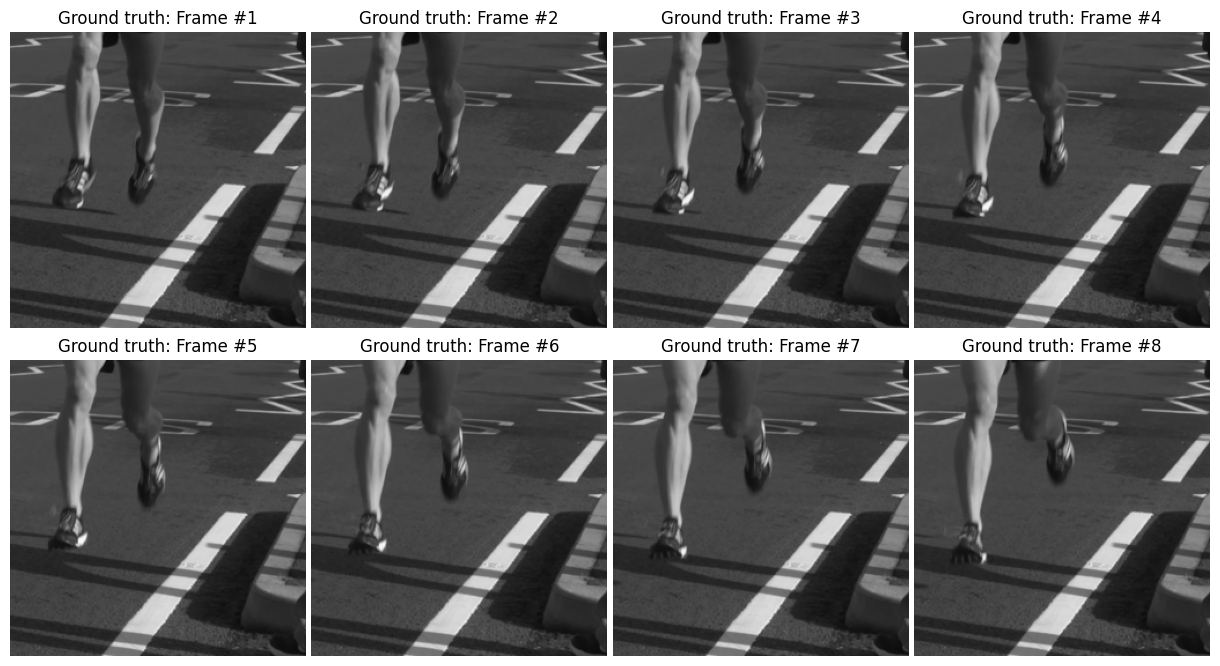

Mean PSNR 36.28 dB.


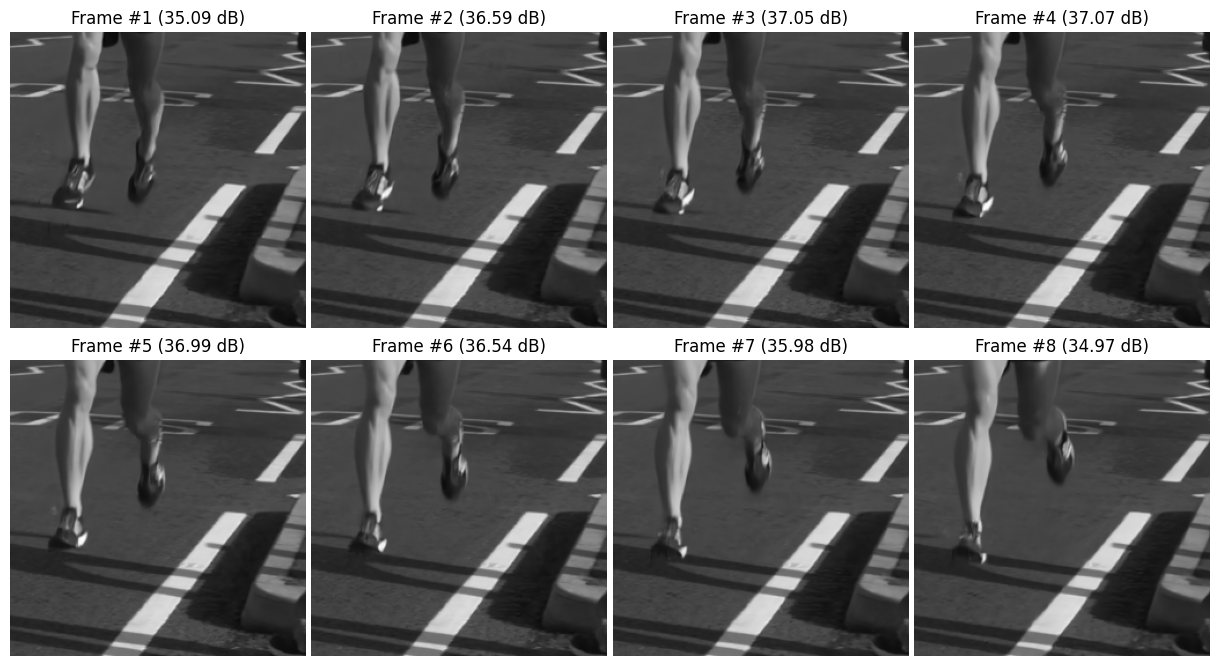

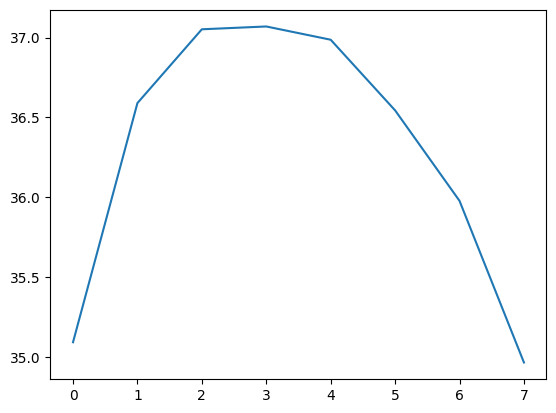

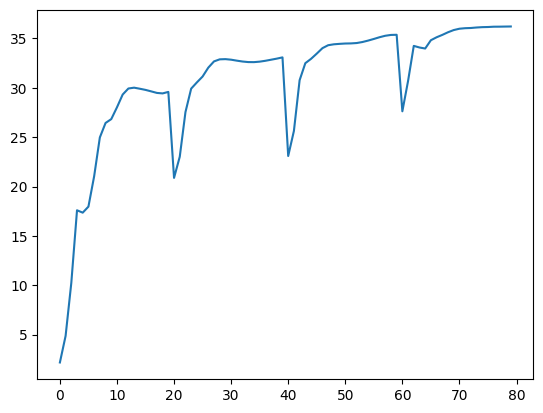

In [64]:
# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgapfastdvdnet
psnr_gapdenoise = psnr_gapfastdvdnet
psnrall_gapdenoise = psnrall_gapfastdvdnet[0]

nmask = mask.shape[2]

fig = plt.figure(figsize=(12, 6.5))
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(orig[:,:,nt]/MAXB, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

fig = plt.figure(figsize=(12, 6.5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    plt.subplot(nmask//4, 4, nt+1)
    plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,psnr_gapdenoise[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(mean(psnr_gapdenoise)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   


plt.figure(2)
# plt.rcParams["font.family"] = 'monospace'
# plt.rcParams["font.size"] = "20"
plt.plot(psnr_gapdenoise)
# plt.plot(psnr_gapdenoise,color='black')
# plt.savefig('./results/savedfig/psnr_framewise_traffic48.png')
plt.show()


plt.figure(3)
plt.plot(psnrall_gapdenoise)
plt.show()
